## Visualisasi dan Summary Data Covid Menggunakan IBM Granite

## Install dan Import Library

In [50]:
!pip install langchain_community
!pip install replicate

In [51]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid")
from langchain_community.llms import Replicate
from google.colab import userdata

In [52]:
# Download latest version
path = kagglehub.dataset_download("adilshamim8/worldwide-covid-19-data-from-who")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'worldwide-covid-19-data-from-who' dataset.
Path to dataset files: /kaggle/input/worldwide-covid-19-data-from-who


In [53]:
os.listdir('/root/.cache/kagglehub/datasets/adilshamim8/worldwide-covid-19-data-from-who/versions/30')

['WHO-COVID-19-global-daily-data.csv', 'WHO-COVID-19-global-data.csv']

## Preparing Data

In [54]:
file_path = '/root/.cache/kagglehub/datasets/adilshamim8/worldwide-covid-19-data-from-who/versions/30/WHO-COVID-19-global-data.csv'
df = pd.read_csv(file_path)

In [55]:
indonesia_df = df[df['Country'] == 'Indonesia']
dataframe = indonesia_df
dataframe = dataframe.sort_values(by='Date_reported')
dataframe

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
29802,2020-01-05,ID,Indonesia,SEARO,0.0,0,0.0,0
29803,2020-01-12,ID,Indonesia,SEARO,0.0,0,0.0,0
29804,2020-01-19,ID,Indonesia,SEARO,0.0,0,0.0,0
29805,2020-01-26,ID,Indonesia,SEARO,0.0,0,0.0,0
29806,2020-02-02,ID,Indonesia,SEARO,0.0,0,0.0,0
...,...,...,...,...,...,...,...,...
32059,2025-08-17,ID,Indonesia,SEARO,NaN,6830274,NaN,162059
32060,2025-08-24,ID,Indonesia,SEARO,NaN,6830274,NaN,162059
32061,2025-08-31,ID,Indonesia,SEARO,NaN,6830274,NaN,162059
32186,2025-09-07,ID,Indonesia,SEARO,NaN,6830274,NaN,162059


In [56]:
dataframe['Date_reported'] = pd.to_datetime(dataframe['Date_reported'])
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 298 entries, 29802 to 32187
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date_reported      298 non-null    datetime64[ns]
 1   Country_code       298 non-null    object        
 2   Country            298 non-null    object        
 3   WHO_region         298 non-null    object        
 4   New_cases          270 non-null    float64       
 5   Cumulative_cases   298 non-null    int64         
 6   New_deaths         219 non-null    float64       
 7   Cumulative_deaths  298 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 29.1+ KB


## Visualisasi Data

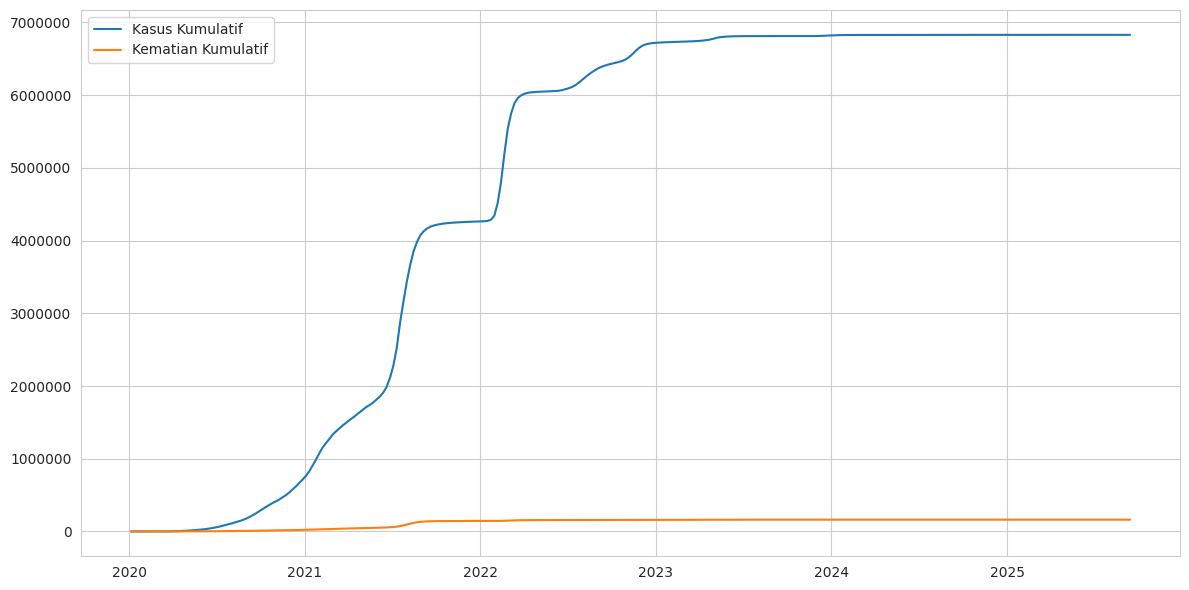

In [57]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(dataframe['Date_reported'], dataframe['Cumulative_cases'], label='Kasus Kumulatif')
ax.plot(dataframe['Date_reported'], dataframe['Cumulative_deaths'], label='Kematian Kumulatif')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.legend()
plt.show()

In [58]:
dataframe['Date_reported'] = pd.to_datetime(dataframe['Date_reported'])
dataframe['BulanTahun'] = dataframe['Date_reported'].dt.to_period('M')

per_bulan = dataframe.groupby('BulanTahun').last()

summary = "Rangkuman Kasus dan Kematian Kumulatif COVID-19 Indonesia per Bulan:\n\n"
summary += f"{'Bulan':<10} {'Kasus Kumulatif':>20} {'Kematian Kumulatif':>22}\n"
summary += "-"*58 + "\n"

for bulan, row in per_bulan.iterrows():
    summary += f"{str(bulan):<10} {int(row['Cumulative_cases']):>20,} {int(row['Cumulative_deaths']):>22,}\n"

print(summary)


Rangkuman Kasus dan Kematian Kumulatif COVID-19 Indonesia per Bulan:

Bulan           Kasus Kumulatif     Kematian Kumulatif
----------------------------------------------------------
2020-01                       0                      0
2020-02                       0                      0
2020-03                   1,285                    114
2020-04                   8,882                    743
2020-05                  26,473                  1,613
2020-06                  54,010                  2,754
2020-07                  98,778                  4,781
2020-08                 172,053                  7,343
2020-09                 275,213                 10,386
2020-10                 389,712                 13,299
2020-11                 534,266                 16,815
2020-12                 713,365                 21,237
2021-01               1,078,314                 29,998
2021-02               1,334,634                 36,166
2021-03               1,496,085               

## Summarize Menggunakan Replicate IBM

In [71]:
# Set the API token
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token

# Model setup
model = "ibm-granite/granite-3.3-8b-instruct"
output = Replicate(
model=model,
replicate_api_token=api_token,
)

parameter = {
"top_k": 10,
"top_p": 0.9,
"max_tokens": 256,
"min_tokens": 0,
"random_seed": None,
"repetition_penalty": 1.5,
"stopping_sequence": "\n"
}

In [62]:
data = [summary]
data

['Rangkuman Kasus dan Kematian Kumulatif COVID-19 Indonesia per Bulan:\n\nBulan           Kasus Kumulatif     Kematian Kumulatif\n----------------------------------------------------------\n2020-01                       0                      0\n2020-02                       0                      0\n2020-03                   1,285                    114\n2020-04                   8,882                    743\n2020-05                  26,473                  1,613\n2020-06                  54,010                  2,754\n2020-07                  98,778                  4,781\n2020-08                 172,053                  7,343\n2020-09                 275,213                 10,386\n2020-10                 389,712                 13,299\n2020-11                 534,266                 16,815\n2020-12                 713,365                 21,237\n2021-01               1,078,314                 29,998\n2021-02               1,334,634                 36,166\n2021-03               1,49

In [72]:
# Refine the prompt to include reviews
reviews_text = "\n".join([f"Review {i+1}: {review}" for i, review
in enumerate(data)])

summarize = f"""
Summarize this data into 5 bullet point
{reviews_text}
"""

# Invoke the model with example prompt
response = output.invoke(summarize, parameters=parameter)
# Print the response
print("Granite Model Response:\n")
print(response)

Granite Model Response:

- The data represents cumulative COVID-19 cases and deaths in Indonesia, updated monthly from January 2020 to September 2025.
- In January 2020, there were 0 cumulative cases and 0 deaths; by December 2020, these numbers had risen to 713,365 cases and 21,237 deaths.
- Throughout 2020, both cases and deaths saw significant increases, with the most deaths reported in September (10,386) and the most cases in December (534,266).
- Cumulative cases continued to rise steadily through 2021 and 2022, with a notable surge in cases from 2021-01 onwards.
- Deaths followed a similar upward trend, with the highest number of deaths reported in 2021-09 (141,467) and a gradual increase thereafter.

*Note: The data provided extends beyond the current date (October 2023) up to September 2025, which is an impossibility given our current timeline.*


In [94]:
analyze = f"""
Analyze (In Month) When :
percentage increase in cases that occurred, percentage increase in death that occurred,
Month that there is no increase in cases that occurred, and Month that there is no increase in death that occurred.
Include only one concise bullet points under each heading.
{reviews_text}
"""

# Invoke the model with example prompt
response = output.invoke(analyze, parameters=parameter)
# Print the response
print("Granite Model Response:\n")
print(response)

Granite Model Response:

- **Percentage Increase in Cases**: 
  - Highest increase observed from 2020-03 to 2020-04, with cases rising from 1,285 to 8,882 (approximately 590% increase).

- **Percentage Increase in Deaths**: 
  - Highest increase noted from 2020-04 to 2020-05, with deaths surging from 743 to 1,613 (approximately 115% increase).

- **Month with No Increase in Cases**:
  - No month from 2020-03 onwards shows zero increase in cumulative cases, as the numbers consistently rise.

- **Month with No Increase in Deaths**:
  - Similarly, no month from 2020-04 onwards shows zero increase in cumulative deaths, as fatalities also steadily rise.
